In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
np.seterr(divide='ignore', invalid='ignore')

from pytpc.hdfdata import HDFDataFile

import pytpc
from pytpc.tpcplot import pad_plot, chamber_plot
from pytpc.constants import degrees, pi

import csv
import yaml
import h5py

In [3]:
evt_id=250

In [4]:
evt_id += 250

910
Event 500, timestamp 0.
Contains 528 traces.


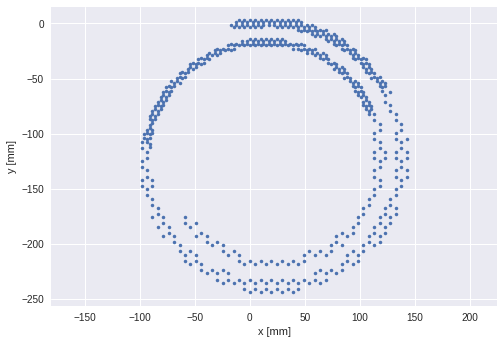

In [8]:
with pytpc.HDFDataFile('../event-gen/data/ptrain_10000.h5','r') as f:
    print(len(f))
    #specific event
    evt = f[evt_id]
    
#     for i in range(20000):
#        print(f[i])
    
    print(evt)
    #trace data from the event
    t = evt.traces

    new_xyz = evt.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
    plt.plot(new_xyz[:,0], new_xyz[:,1], '.')
    plt.axis('equal')
        
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    
    #plt.savefig('/home/taylor/Documents/independent-research/event-gen/plots/evtxy_p.pdf')

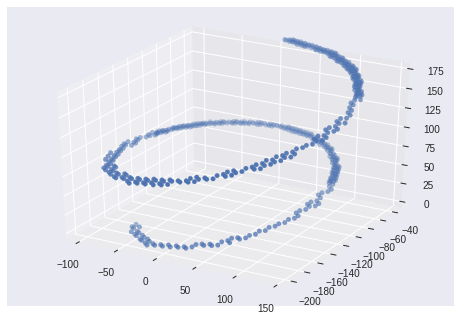

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
with pytpc.HDFDataFile('../event-gen/data/ptrain_10000.h5', 'r') as f:
    n_evts = len(f)
    evt = f[evt_id]
    t = evt.traces['data']
    new_xyz = evt.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
    ax.scatter(new_xyz[:,0], new_xyz[:,1],new_xyz[:,2])
    ax.axis('equal')

In [37]:
DETECTOR_LENGTH = 1000.0
DETECTOR_RADIUS = 275.0

In [38]:
#Discretization vars (Integers)

x_disc = 20
y_disc = 20
z_disc = 20

print("These values will downsample the xyz scattering data into " + str(x_disc*y_disc*z_disc) + " sections/features")

These values will downsample the xyz scattering data into 8000 sections/features


In [39]:
x_inc = (2*DETECTOR_RADIUS)/x_disc
y_inc = (2*DETECTOR_RADIUS)/y_disc
z_inc = DETECTOR_LENGTH/z_disc

In [8]:
x_slices = np.arange(-DETECTOR_RADIUS, DETECTOR_RADIUS + x_inc, x_inc)
y_slices = np.arange(-DETECTOR_RADIUS, DETECTOR_RADIUS + y_inc, y_inc)
z_slices = np.arange(0.0, DETECTOR_LENGTH + z_inc, z_inc)

print(x_slices)
print(y_slices)
print(z_slices)

[-275.  -247.5 -220.  -192.5 -165.  -137.5 -110.   -82.5  -55.   -27.5
    0.    27.5   55.    82.5  110.   137.5  165.   192.5  220.   247.5
  275. ]
[-275.  -247.5 -220.  -192.5 -165.  -137.5 -110.   -82.5  -55.   -27.5
    0.    27.5   55.    82.5  110.   137.5  165.   192.5  220.   247.5
  275. ]
[    0.    50.   100.   150.   200.   250.   300.   350.   400.   450.
   500.   550.   600.   650.   700.   750.   800.   850.   900.   950.
  1000.]


In [27]:
evt_id=107

In [29]:
with pytpc.HDFDataFile('/home/taylor/Documents/independent-research/event-gen/data/ptrain_10000.h5', 'r') as f:
    n_evts = len(f)
    evt = f[evt_id]
    t = evt.traces['data']
    new_xyz = evt.xyzs(peaks_only=True, return_pads=True, baseline_correction=False, cg_times=False)
    print(new_xyz)

[[ -7.36235272e+00   7.05056055e+00   2.04000000e+02   3.30000000e+01
    1.43000000e+02]
 [ -4.90823515e+00   5.70140844e+00   2.04000000e+02   2.50000000e+01
    1.46000000e+02]
 [ -2.45411757e+00   7.05056055e+00   2.04000000e+02   2.41000000e+02
    1.48000000e+02]
 ..., 
 [  7.85317624e+01   2.32403079e+02   1.66000000e+02   3.74000000e+02
    4.94600000e+03]
 [  8.34399975e+01   2.35372317e+02   1.65000000e+02   9.00000000e+00
    4.94700000e+03]
 [  8.83482327e+01   2.32403079e+02   1.65000000e+02   9.00000000e+00
    4.94800000e+03]]


In [11]:
#brute force discretization - high cost
discretized_dataBRUTE = np.zeros((1,x_disc*y_disc*z_disc))
discretized_xyzBRUTE = np.zeros([new_xyz.shape[0],new_xyz.shape[1]])

bucket_num = 0
num_pts = 0

for i in range(len(z_slices)-1):
    for j in range(len(x_slices)-1):
        for k in range(len(y_slices)-1):
            for point in new_xyz:
                if ((z_slices[i] < point[2] < z_slices[i+1]) and 
                    (x_slices[j] < point[0] < x_slices[j+1]) and 
                    (y_slices[k] < point[1] < y_slices[k+1])):
                    discretized_dataBRUTE[0][bucket_num] = 1
                    num_pts += 1
                    
                    #reassigning xyz values based on bucket
                    avg_z = (z_slices[i]+z_slices[i+1])/2.0
                    avg_x = (x_slices[j]+x_slices[j+1])/2.0
                    avg_y = (y_slices[k]+y_slices[k+1])/2.0
                    
                    discretized_xyzBRUTE[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
                                                
            bucket_num += 1         
            
print(bucket_num)
print("points found: " + str(num_pts) + "   ||   points in data: " + str(len(new_xyz)))
print("buckets filled: " + str(discretized_dataBRUTE.sum()))

8000
points found: 678   ||   points in data: 696
buckets filled: 67.0


In [20]:
#reduce to O(n) - calculate bucket indices based on increments/ total lengths
#neccesary for disctretizing large amounts of data
discElements = x_disc*y_disc*z_disc
discretized_data = np.zeros((1, discElements))
discretized_dataCHARGE = np.zeros((1, discElements))

buckets = []

discretized_xyz = np.zeros([new_xyz.shape[0],new_xyz.shape[1]])

num_pts = 0

for point in new_xyz:
    x_bucket = math.floor(((point[0]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*x_disc)
    y_bucket = math.floor(((point[1]+DETECTOR_RADIUS)/(2*DETECTOR_RADIUS))*y_disc)
    z_bucket = math.floor((point[2]/DETECTOR_LENGTH)*z_disc)

    bucket_num = z_bucket*x_disc*y_disc + x_bucket + y_bucket*x_disc
    discretized_data[0,bucket_num] = 1
    discretized_dataCHARGE[0,bucket_num] += point[3]/100

    
    #sparse matrix implementation
    buckets.append(bucket_num)
    
    avg_x = -DETECTOR_RADIUS + ((2*x_bucket+1)*x_inc)/2.0
    avg_y = -DETECTOR_RADIUS + ((2*y_bucket+1)*y_inc)/2.0
    avg_z = ((2*z_bucket+1)*z_inc)/2.0                          
    
    discretized_xyz[num_pts] = [avg_x, avg_y, avg_z, point[3], point[4]]
    
    num_pts += 1

#create csr matrix where data is np.ones(len(col)) and row np.zeros(len(col)) of size (1, discElements)
cols = np.unique(buckets)
rows = np.zeros(len(cols))
data = np.ones(len(cols))
discretized_data_sparse  = sp.sparse.csr_matrix((data, (rows, cols)), shape=(1, discElements))

print("buckets filled: " + str(discretized_data.sum()))
print("charge acumulated: " + str(discretized_dataCHARGE.sum()))

buckets filled: 70.0
charge acumulated: 2663.97


In [ ]:
print(new_xyz.shape)
print(discretized_data.shape)
print(discretized_data_sparse.shape)

In [ ]:
print(np.count_nonzero((discretized_data == discretized_data_sparse.todense()) == False ))
print(np.count_nonzero((discretized_data == discretized_data_sparse.todense()) == True ))

In [ ]:
fig, ax = plt.subplots(1, 3, squeeze=True, figsize=(18, 6))

ax[0].plot(new_xyz[:,0], new_xyz[:,1], '.')
ax[0].axis('equal')
        
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[0].set_title('Original Data')

#######################################################################################################################
ax[1].plot(discretized_xyzBRUTE[:,0], discretized_xyzBRUTE[:,1], '.')
ax[1].axis('equal')
        
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
ax[1].set_title('Brute Force Downsampled Data')

#######################################################################################################################
ax[2].plot(discretized_xyz[:,0], discretized_xyz[:,1], '.')
ax[2].axis('equal')
        
ax[2].set_xlabel('x [mm]')
ax[2].set_ylabel('y [mm]')
ax[2].set_title('Efficeintly Downsampled Data')

In [ ]:
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(new_xyz[:,0], new_xyz[:,1], new_xyz[:,2])
ax.axis('equal')
ax.set_title("Original Data")

#######################################################################################################################
ax = fig.add_subplot(2, 3, 2, projection='3d')
ax.scatter(discretized_xyzBRUTE[:,0], discretized_xyzBRUTE[:,1], discretized_xyzBRUTE[:,2])
ax.axis('equal')
ax.set_title('Brute Force Downsampled Data')

#######################################################################################################################
ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.scatter(discretized_xyz[:,0], discretized_xyz[:,1], discretized_xyz[:,2])
ax.axis('equal')
ax.set_title('Efficiently Downsampled Data')

In [ ]:
np.ones(30).shape

In [ ]:
rows = np.full((len(cols),), evt_id)
print(rows)

In [1]:
chamber_plot(new_xyz[:])
#plt.savefig('/home/taylor/Documents/independent-research/plots/chamberFullRes.pdf')

NameError: name 'chamber_plot' is not defined

In [ ]:
chamber_plot(discretized_xyz[:])
#plt.savefig('/home/taylor/Documents/independent-research/plots/chamberFullDisc.pdf')

In [ ]:
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(new_xyz[:,0], new_xyz[:,1], new_xyz[:,2])
ax.axis('equal')
#ax.set_title("Original Data")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#######################################################################################################################
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.scatter(discretized_xyz[:,0], discretized_xyz[:,1], discretized_xyz[:,2])
ax.axis('equal')
#ax.set_title('Efficiently Downsampled Data')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.savefig('/home/taylor/Documents/independent-research/plots/xyzDisc.pdf')

NameError: name 'pytpc' is not defined

512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512


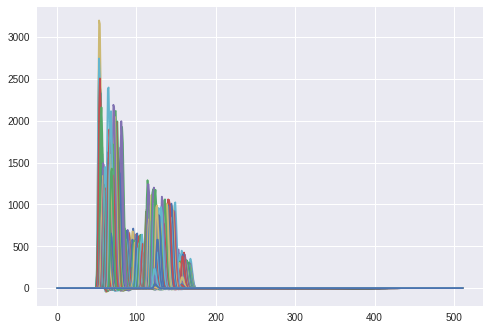

In [8]:
f = pytpc.HDFDataFile('../data/NO-tilt/p_40000.h5', 'r')
evt = f[2] 

for trace in evt.traces['data']:
    plt.plot(trace)
    print(len(trace))